In [1]:
# import required modules
import numpy as np
import pandas as pd
from collections import Counter
import statistics

import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
# import data
allFactors = pd.read_csv('/scratch1/qiushipe/data_reusability/data_tables/Metadata_Matrix_raw.csv', low_memory = False)
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess
0,PMC6279764,SRP073810,GSE80651,GEO,2018-12-04,2016-10-24,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN
1,PMC8633104,SRP093349,GSE89843,GEO,2021-11-12,2017-08-15,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN
2,PMC8542793,SRP010905,GSE35724,GEO,2021-10-11,2013-10-18,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN
3,PMC8542793,SRP029602,GSE50612,GEO,2021-10-11,2015-01-01,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN
4,PMC8542793,SRP029985,GSE50934,GEO,2021-10-11,2014-06-10,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN


In [3]:
# drop lines with column "pmc_date" euqals "error"
allFactors = allFactors[~allFactors['pmc_date'].isin(['error'])]

In [4]:
# Tag each paper as either a generator or a reuser

# take each converted accession along with the first date it appears in a paper
EarliestDate = allFactors.loc[:, ['converted_accession', 'pmc_date']].drop_duplicates()
EarliestDate = EarliestDate.groupby('converted_accession', as_index = False).agg({'pmc_date': 'min'})
EarliestDate = EarliestDate.rename(columns = {'pmc_date':'min_pmc_date'})

# label all of the usages of these datasets on these dates with a 'G' (generators)
EarliestDate.loc[:,'reuse_role'] = 'G'
ReuseRole = EarliestDate

In [5]:
ReuseRole

,converted_accession,min_pmc_date,reuse_role
0,DRP000009,2012-01-27,G
1,DRP000010,2010-04-27,G
2,DRP000017,2011-08-09,G
3,DRP000018,2011-08-09,G
4,DRP000019,2011-08-09,G
...,...,...,...
131854,SRP361642,2020-07-22,G
131855,SRP362459,2020-10-19,G
131856,SRP364367,2019-05-07,G
131857,SRP364819,2021-10-06,G


In [6]:
# merge these back onto the original table, matching dates back to papers
allFactors = pd.merge(allFactors, ReuseRole, how = 'left', 
                      left_on = ['converted_accession', 'pmc_date'], 
                      right_on = ['converted_accession', 'min_pmc_date'])

# label every usage of a dataset that isn't 'G' (generator) as 'R' (reuser)
allFactors['allR'] = 'R'
allFactors['reuse_role'] = allFactors['reuse_role'].fillna(allFactors['allR'])

# drop redundant columns
allFactors = allFactors.drop(labels = ['min_pmc_date', 'allR'], axis = 1)
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role
0,PMC6279764,SRP073810,GSE80651,GEO,2018-12-04,2016-10-24,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R
1,PMC8633104,SRP093349,GSE89843,GEO,2021-11-12,2017-08-15,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R
2,PMC8542793,SRP010905,GSE35724,GEO,2021-10-11,2013-10-18,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R
3,PMC8542793,SRP029602,GSE50612,GEO,2021-10-11,2015-01-01,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R
4,PMC8542793,SRP029985,GSE50934,GEO,2021-10-11,2014-06-10,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R


In [7]:
# Get the count of each dataset (GEO Series or SRA Study) in each primary analysis paper

# take slice of "Generator" from allFactors
Gen = allFactors.loc[allFactors['reuse_role'] == 'G', :]
Gen = Gen.loc[:, ['pmc_ID', 'converted_accession', 'reuse_role']]

PrimUseCount = Gen.drop_duplicates().groupby(['pmc_ID', 'converted_accession']).count().reset_index().rename(columns = {'reuse_role' : 'prim_use_count'}).drop(['pmc_ID'], axis = 1)
PrimUseCount

,converted_accession,prim_use_count
0,GSE2227,1
1,GSE1939,1
2,GSE366,1
3,GSE2193,1
4,GSE2031,1
...,...,...
131978,SRP336544,1
131979,GSE180478,1
131980,GSE184997,1
131981,GSE174687,1


In [8]:
# merge PrimUseCount and allFactors
allFactors = pd.merge(allFactors, PrimUseCount, on = 'converted_accession', how = 'left')

In [9]:
# count reuse
justAcc = allFactors.loc[:, ['pmc_ID', 'converted_accession']].drop_duplicates()
rc_counter = Counter(justAcc['converted_accession'])
reuse_counts = pd.DataFrame.from_dict(rc_counter, orient = 'index').reset_index()
reuse_counts.columns = ['converted_accession', 'total_use_count']
reuse_counts

,converted_accession,total_use_count
0,GSE80651,2
1,GSE89843,11
2,GSE35724,5
3,GSE50612,8
4,GSE50934,8
...,...,...
131854,ERP105161,1
131855,SRP132165,1
131856,GSE143744,1
131857,GSE101692,1


In [10]:
# merge reuse counts onto table
allFactors = pd.merge(allFactors, reuse_counts, how = 'left', on = 'converted_accession')
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count
0,PMC6279764,SRP073810,GSE80651,GEO,2018-12-04,2016-10-24,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,2
1,PMC8633104,SRP093349,GSE89843,GEO,2021-11-12,2017-08-15,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,11
2,PMC8542793,SRP010905,GSE35724,GEO,2021-10-11,2013-10-18,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,5
3,PMC8542793,SRP029602,GSE50612,GEO,2021-10-11,2015-01-01,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,8
4,PMC8542793,SRP029985,GSE50934,GEO,2021-10-11,2014-06-10,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,8


In [11]:
# caculate secondary use count (reuse times)
allFactors['sec_use_count'] = allFactors['total_use_count'] - allFactors['prim_use_count']
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count
0,PMC6279764,SRP073810,GSE80651,GEO,2018-12-04,2016-10-24,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,2,1
1,PMC8633104,SRP093349,GSE89843,GEO,2021-11-12,2017-08-15,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,11,10
2,PMC8542793,SRP010905,GSE35724,GEO,2021-10-11,2013-10-18,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,5,4
3,PMC8542793,SRP029602,GSE50612,GEO,2021-10-11,2015-01-01,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,8,7
4,PMC8542793,SRP029985,GSE50934,GEO,2021-10-11,2014-06-10,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,8,7


In [12]:
# normalize reuse count by amount of time public

# convert repository upload dates and today's date to datetime objects
allFactors.loc[:,'repository_date'] = allFactors['repository_date'].replace({' ':''})
allFactors.loc[:,'repository_date'] = pd.to_datetime(allFactors['repository_date'], format = '%Y-%m-%d')
allFactors['today'] = date.today().strftime('%Y-%m-%d')
allFactors['today'] = pd.to_datetime(allFactors['today'], format = '%Y-%m-%d')

# create timedelta objects representing amount of time public in YEARS
allFactors['time_public'] = allFactors['today'] - allFactors['repository_date']
allFactors['time_public'] = allFactors['time_public'].dt.days / 365

# normalize reuse count by years public
allFactors['norm_reuse_count'] = allFactors['sec_use_count'] / allFactors['time_public']
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count,today,time_public,norm_reuse_count
0,PMC6279764,SRP073810,GSE80651,GEO,2018-12-04,2016-10-24,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,2,1,2023-02-16,6.317808,0.158283
1,PMC8633104,SRP093349,GSE89843,GEO,2021-11-12,2017-08-15,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,11,10,2023-02-16,5.509589,1.815017
2,PMC8542793,SRP010905,GSE35724,GEO,2021-10-11,2013-10-18,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,5,4,2023-02-16,9.336986,0.428404
3,PMC8542793,SRP029602,GSE50612,GEO,2021-10-11,2015-01-01,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,8,7,2023-02-16,8.131507,0.860849
4,PMC8542793,SRP029985,GSE50934,GEO,2021-10-11,2014-06-10,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,8,7,2023-02-16,8.693151,0.805232


### perform QC

In [13]:
# take slice of "Generator" from allFactors
gens = allFactors.loc[allFactors['reuse_role'] == 'G', :]
gens

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count,today,time_public,norm_reuse_count
26,PMC4830539,GSE60793,E-GEOD-60793,NaN,2016-04-13,NaT,NaN,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,NaN,NaN
29,PMC4191404,GSE54454,E-GEOD-54454,NaN,2014-09-23,NaT,NaN,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,NaN,NaN
31,PMC6292174,SRR2992615,GSE75956,GEO,2018-12-13,2017-02-09,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,6.021918,0.000000
32,PMC6292174,SRR2992616,GSE75956,GEO,2018-12-13,2017-02-09,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,6.021918,0.000000
33,PMC6292174,SRR2992619,GSE75956,GEO,2018-12-13,2017-02-09,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,6.021918,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354975,PMC6219076,SRP132165,SRP132165,SRA,2018-11-06,2018-03-29,Spodoptera frugiperda,Illumina HiSeq 2500,miRNA-Seq,20.0,1.721086e+09,public,G,1,1,0,2023-02-16,4.890411,0.000000
354976,PMC7066330,GSE143744,GSE143744,GEO,2020-02-20,2020-01-17,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,3.084932,0.000000
354977,PMC7066330,GSE143743,GSE143743,GEO,2020-02-20,2020-01-17,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,2,1,2023-02-16,3.084932,0.324156
354978,PMC5714895,GSE101692,GSE101692,GEO,2017-11-30,2018-01-12,Glycine max,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,5.098630,0.000000


In [14]:
# convert to date objects
gens.loc[:,'pmc_date'] = pd.to_datetime(gens['pmc_date'], format = '%Y-%m-%d', errors = 'coerce')
gens.loc[:,'repository_date'] = pd.to_datetime(gens['repository_date'], format = '%Y-%m-%d')

/tmp/SLURM_13727089/ipykernel_20494/356575527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens.loc[:,'pmc_date'] = pd.to_datetime(gens['pmc_date'], format = '%Y-%m-%d', errors = 'coerce')
/tmp/SLURM_13727089/ipykernel_20494/356575527.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens.loc[:,'repository_date'] = pd.to_datetime(gens['repository_date'], format = '%Y-%m-%d')


In [15]:
# subtract columns of date objects, creating a column of timedelta objects
gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']
gens = gens.dropna(subset = ['pub_delay'])

/tmp/SLURM_13727089/ipykernel_20494/202041214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']


In [16]:
# convert timedeltas back to integers
gens.loc[:,'pub_delay'] = gens['pub_delay'].dt.days
gens = gens.sort_values(by = 'pub_delay', ascending = False)
gens

/tmp/SLURM_13727089/ipykernel_20494/2768328244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens.loc[:,'pub_delay'] = gens['pub_delay'].dt.days


,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count,today,time_public,norm_reuse_count,pub_delay
118691,PMC8553153,GSE45,GSE45,GEO,2021-10-28,2002-06-27,Homo sapiens,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,20.654795,0.000000,7063
120766,PMC8527884,GSE42,GSE42,GEO,2021-10-06,2002-07-22,Mus musculus,SAGE NlaIII,Expression_Array,NaN,NaN,NaN,G,1,1,0,2023-02-16,20.586301,0.000000,7016
313213,PMC7670042,GSE15,GSE15,GEO,2020-11-03,2002-01-03,Mus musculus,NaN,NaN,NaN,NaN,NaN,G,1,2,1,2023-02-16,21.134247,0.047317,6879
83116,PMC7733691,GDS46,GSE498,GEO,2020-12-13,2002-02-27,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,G,1,2,1,2023-02-16,20.983562,0.047656,6864
258103,PMC8515845,GSE84,GSE84,GEO,2021-09-30,2003-01-03,Saccharum sp.,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,20.134247,0.000000,6845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139533,PMC3406062,SRP002463,SRP002463,SRA,2012-07-26,2021-12-15,human metagenome,Illumina HiSeq 2500,AMPLICON,602.0,37103066.0,filtered,G,1,1,0,2023-02-16,1.172603,0.000000,-3429
112304,PMC3159013,GSE151716,GSE151716,GEO,2011-08-02,2021-04-15,Caenorhabditis elegans,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,1.841096,0.000000,-3544
57285,PMC3014295,GSE157442,GSE157442,GEO,2010-11-30,2020-09-04,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,2.452055,0.000000,-3566
90147,PMC2874554,SRR000905,SRP000109,SRA,2010-04-13,2020-12-05,metagenome,AB 310 Genetic Analyzer,WGS,907.0,52869317.0,public,G,1,11,10,2023-02-16,2.200000,4.545455,-3889


/home1/qiushipe/.conda/envs/myenv/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pub_delay', ylabel='Density'>

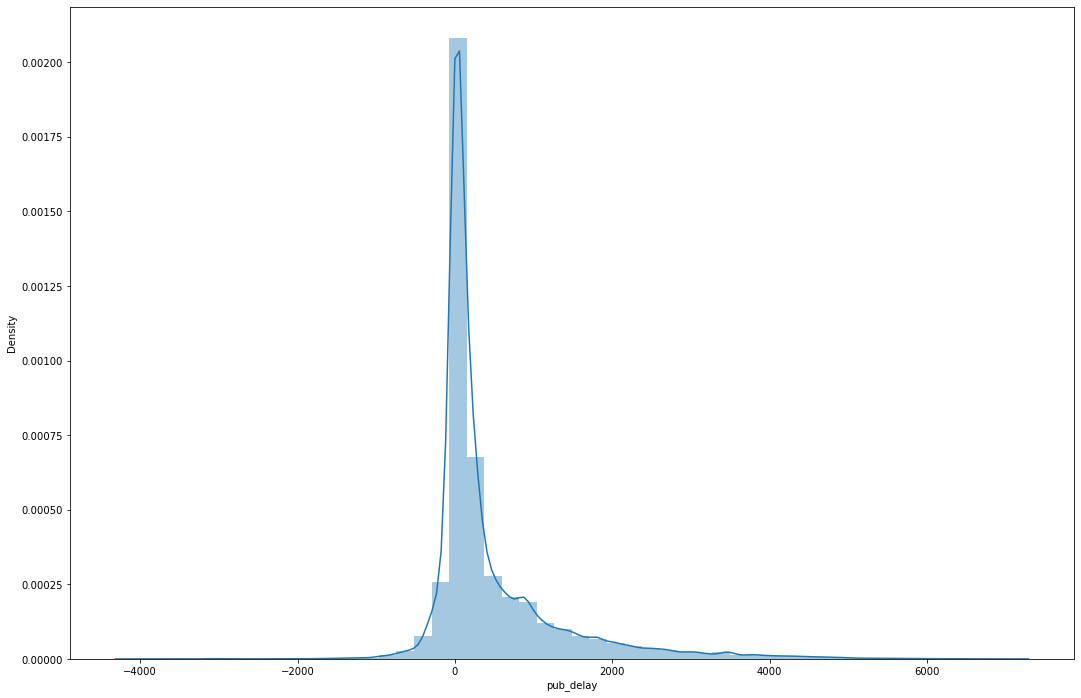

In [17]:
# plot timedelta distribution
fig_dims = (18,12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(gens['pub_delay'], ax = ax)

In [18]:
# select only papers in a reasonable timedelta window

DELAY_MIN = -270
DELAY_MAX = 270

gens_filtered = gens.loc[gens['pub_delay'] <= DELAY_MAX, :].loc[gens['pub_delay'] >= DELAY_MIN, :]
gens_filtered

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count,today,time_public,norm_reuse_count,pub_delay
310147,PMC8313235,GSE160364,GSE160364,GEO,2021-07-26,2020-10-29,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,2.301370,0.000000,270
89333,PMC5240201,SRR3397074,SRP073394,SRA,2017-01-17,2016-04-22,Bacillus cereus ATCC 10987,Illumina MiSeq,WGS,144.0,3.354071e+08,public,G,1,1,0,2023-02-16,6.824658,0.000000,270
89334,PMC5240201,SRR3397076,SRP073395,SRA,2017-01-17,2016-04-22,Homo sapiens,HiSeq X Ten,WGS,302.0,1.508561e+11,public,G,1,1,0,2023-02-16,6.824658,0.000000,270
263167,PMC3384622,GSE24819,GSE24819,GEO,2012-06-27,2011-10-01,Mus musculus,spotted oligonucleotide,Expression_Array,NaN,NaN,NaN,G,1,2,1,2023-02-16,11.386301,0.087825,270
28462,PMC6988223,GSE130645,GSE130645,GEO,2020-01-28,2019-05-03,Homo sapiens,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,3.794521,0.000000,270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172681,PMC6305283,SRP158656,SRP158656,SRA,2018-12-18,2019-09-14,Arachis hypogaea,Illumina HiSeq 4000,RAD-Seq,195.0,2.376483e+09,public,G,1,1,0,2023-02-16,3.427397,0.000000,-270
307641,PMC5897423,SRP127505,SRP127505,SRA,2018-04-06,2019-01-01,mouse gut metagenome,Illumina MiSeq,AMPLICON,101.0,1.175996e+08,public,G,1,1,0,2023-02-16,4.128767,0.000000,-270
293997,PMC5010306,DRA004333,DRP003564,SRA,2016-07-08,2017-04-04,Malus domestica,Illumina Genome Analyzer IIx,WGS,152.0,4.462566e+10,public,G,1,1,0,2023-02-16,5.873973,0.000000,-270
54959,PMC5910558,GSE98370,GSE98370,GEO,2018-04-20,2019-01-15,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,3,2,2023-02-16,4.090411,0.488948,-270


In [19]:
# select random papers inside/outside threshold for QC analysis
import random

# gens_filtered are inside threshold already
# get papers outside threshold, but within 365 days

DELAY_EDGE = 365

gens_aboveThresh = gens.loc[gens['pub_delay'] >= DELAY_MAX, :].loc[gens['pub_delay'] <= DELAY_EDGE]
gens_aboveThresh = gens_aboveThresh.loc[gens_aboveThresh['repository'] == "GEO", :]
gens_belowThresh = gens.loc[gens['pub_delay'] <= DELAY_MIN, :].loc[gens['pub_delay'] >= -DELAY_EDGE]
gens_belowThresh = gens_belowThresh.loc[gens_belowThresh['repository'] == "GEO", :]
gens_insideThresh = gens_filtered.loc[gens_filtered['repository'] == "GEO", :]

num_papers = 50
half_papers = int(num_papers / 2)

# take random samples inside, above, and below threshold
rand_in = pd.DataFrame(random.sample(gens_insideThresh['pmc_ID'].tolist(), num_papers))
rand_in.columns = ['pmc_ID']
rand_ab = pd.DataFrame(random.sample(gens_aboveThresh['pmc_ID'].tolist(), half_papers))
rand_ab.columns = ['pmc_ID']
rand_be = pd.DataFrame(random.sample(gens_belowThresh['pmc_ID'].tolist(), half_papers))
rand_be.columns = ['pmc_ID']

# match accessions to papers to make manual work easier
r_in = pd.merge(rand_in, gens_insideThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_in['real_introducer'] = np.NaN
r_ab = pd.merge(rand_ab, gens_aboveThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_be = pd.merge(rand_be, gens_belowThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_out = pd.concat([r_ab, r_be])
r_out['real_introducer'] = np.NaN

# save incomplete files to csv
r_in.to_csv('/scratch1/qiushipe/data_reusability/data_tables/randomIntroducers_INSIDE.csv', index = False)
r_out.to_csv('/scratch1/qiushipe/data_reusability/data_tables/randomIntroducers_OUTSIDE.csv', index = False)

In [20]:
# fill the column "real_introducer" manully, and rename the files "randomIntroducers_INSIDE_270days_filledin.csv" and "randomIntroducers_OUTSIDE_270days_filledin.csv"
# validate each of these randomly selected paper-dataset relationships

# import the manually produced data (now complete files)
rinf = pd.read_csv('/scratch1/qiushipe/data_reusability/data_tables/randomIntroducers_INSIDE_270days_filledin.csv').dropna()
routf = pd.read_csv('/scratch1/qiushipe/data_reusability/data_tables/randomIntroducers_OUTSIDE_270days_filledin.csv').dropna()

# create a true positive column
# true positive means PMC_ID == REAL_INTRODUCER
rinf['TP'] = np.where(rinf['pmc_ID'] == rinf['real_introducer'], True, False)
routf['TN'] = np.where(routf['pmc_ID'] != routf['real_introducer'], True, False)

# reduce the tables to just PMC_ID and TP/TN
rinf = rinf[['pmc_ID', 'TP']].drop_duplicates()
routf = routf[['pmc_ID', 'TN']].drop_duplicates()

tp = statistics.mean(rinf['TP'])
tn = statistics.mean(routf['TN'])

print('True Positive rate (inside threshold): ' + str(tp))
print('True Negative rate (outside threshold, inside year): ' + str(tn))

True Positive rate (inside threshold): 0.8333333333333334
True Negative rate (outside threshold, inside year): 0.3488372093023256


In [21]:
not_gens = allFactors.loc[allFactors['reuse_role'] != 'G', :]
filtered_matrix = pd.concat(objs = [gens_filtered, not_gens], ignore_index = True, sort = False)
filtered_matrix

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count,today,time_public,norm_reuse_count,pub_delay
0,PMC8313235,GSE160364,GSE160364,GEO,2021-07-26 00:00:00,2020-10-29,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,G,1,1,0,2023-02-16,2.301370,0.000000,270.0
1,PMC5240201,SRR3397074,SRP073394,SRA,2017-01-17 00:00:00,2016-04-22,Bacillus cereus ATCC 10987,Illumina MiSeq,WGS,144.0,3.354071e+08,public,G,1,1,0,2023-02-16,6.824658,0.000000,270.0
2,PMC5240201,SRR3397076,SRP073395,SRA,2017-01-17 00:00:00,2016-04-22,Homo sapiens,HiSeq X Ten,WGS,302.0,1.508561e+11,public,G,1,1,0,2023-02-16,6.824658,0.000000,270.0
3,PMC3384622,GSE24819,GSE24819,GEO,2012-06-27 00:00:00,2011-10-01,Mus musculus,spotted oligonucleotide,Expression_Array,NaN,NaN,NaN,G,1,2,1,2023-02-16,11.386301,0.087825,270.0
4,PMC6988223,GSE130645,GSE130645,GEO,2020-01-28 00:00:00,2019-05-03,Homo sapiens,NaN,NaN,NaN,NaN,NaN,G,1,1,0,2023-02-16,3.794521,0.000000,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289580,PMC8435749,SRP128359,SRP128359,SRA,2021-08-30,2019-09-17,Suaeda aralocaspica,NextSeq 500,WGS,285.0,1.707052e+10,public,R,1,3,2,2023-02-16,3.419178,0.584936,NaN
289581,PMC8435749,PRJNA325861,SRP076752,SRA,2021-08-30,2017-06-19,Suaeda aralocaspica,Illumina HiSeq 2000,miRNA-Seq,100.0,4.271994e+08,public,R,1,2,1,2023-02-16,5.665753,0.176499,NaN
289582,PMC8360842,GSE81089,GSE81089,GEO,2021-02-12,2016-06-01,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,NaN,NaN,R,1,35,34,2023-02-16,6.715068,5.063239,NaN
289583,PMC8360842,GSE37745,GSE37745,GEO,2021-02-12,2012-10-12,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,NaN,R,1,221,220,2023-02-16,10.353425,21.249008,NaN


In [22]:
lsc = Counter(filtered_matrix.loc[filtered_matrix['repository'] == "SRA", ]["library_strategy"])
lsc_df = pd.DataFrame.from_dict(lsc, orient = 'index').reset_index()
sraLS = list(lsc_df["index"])
sraLS.remove("RNA-Seq")
sraLS

['WGS',
 'AMPLICON',
 'OTHER',
 'miRNA-Seq',
 'WXS',
 'Bisulfite-Seq',
 'WGA',
 'FL-cDNA',
 'MRE-Seq',
 'ChIP-Seq',
 'RAD-Seq',
 'CLONE',
 'RIP-Seq',
 'ATAC-seq',
 'POOLCLONE',
 'Targeted-Capture',
 'Hi-C',
 'other',
 'WCS',
 'DNase-Hypersensitivity',
 'EST',
 'MNase-Seq',
 'MeDIP-Seq',
 'Tn-Seq',
 'MBD-Seq',
 'CTS',
 'Synthetic-Long-Read',
 'ncRNA-Seq',
 'SELEX',
 'ChIA-PET',
 'CLONEEND',
 'Tethered Chromatin Conformation Capture',
 'FINISHING']

In [23]:
# add a column for "class"... separating GEO/SRA distinction into:
# (1) GEO gene expression
# (2) RNA-seq (GEO and SRA)
# (3) SRA other omics technologies

key = {"repository": ["GEO", "GEO", "SRA"] + ["SRA"]*(len(sraLS)), 
       "library_strategy": ["Expression_Array", "RNA-Seq", "RNA-Seq"] + sraLS,
      "class": ["GEO_expr", "RNA-Seq", "RNA-Seq"] + ["SRA_other"]*(len(sraLS))}
key = pd.DataFrame(key)
key

,repository,library_strategy,class
0,GEO,Expression_Array,GEO_expr
1,GEO,RNA-Seq,RNA-Seq
2,SRA,RNA-Seq,RNA-Seq
3,SRA,WGS,SRA_other
4,SRA,AMPLICON,SRA_other
5,SRA,OTHER,SRA_other
6,SRA,miRNA-Seq,SRA_other
7,SRA,WXS,SRA_other
8,SRA,Bisulfite-Seq,SRA_other
9,SRA,WGA,SRA_other


In [24]:
filtered_matrix = pd.merge(filtered_matrix, key, how = 'left', on = ['repository', 'library_strategy'])
filtered_matrix

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,...,sraAccess,reuse_role,prim_use_count,total_use_count,sec_use_count,today,time_public,norm_reuse_count,pub_delay,class
0,PMC8313235,GSE160364,GSE160364,GEO,2021-07-26 00:00:00,2020-10-29,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,...,NaN,G,1,1,0,2023-02-16,2.301370,0.000000,270.0,RNA-Seq
1,PMC5240201,SRR3397074,SRP073394,SRA,2017-01-17 00:00:00,2016-04-22,Bacillus cereus ATCC 10987,Illumina MiSeq,WGS,144.0,...,public,G,1,1,0,2023-02-16,6.824658,0.000000,270.0,SRA_other
2,PMC5240201,SRR3397076,SRP073395,SRA,2017-01-17 00:00:00,2016-04-22,Homo sapiens,HiSeq X Ten,WGS,302.0,...,public,G,1,1,0,2023-02-16,6.824658,0.000000,270.0,SRA_other
3,PMC3384622,GSE24819,GSE24819,GEO,2012-06-27 00:00:00,2011-10-01,Mus musculus,spotted oligonucleotide,Expression_Array,NaN,...,NaN,G,1,2,1,2023-02-16,11.386301,0.087825,270.0,GEO_expr
4,PMC6988223,GSE130645,GSE130645,GEO,2020-01-28 00:00:00,2019-05-03,Homo sapiens,NaN,NaN,NaN,...,NaN,G,1,1,0,2023-02-16,3.794521,0.000000,270.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289580,PMC8435749,SRP128359,SRP128359,SRA,2021-08-30,2019-09-17,Suaeda aralocaspica,NextSeq 500,WGS,285.0,...,public,R,1,3,2,2023-02-16,3.419178,0.584936,NaN,SRA_other
289581,PMC8435749,PRJNA325861,SRP076752,SRA,2021-08-30,2017-06-19,Suaeda aralocaspica,Illumina HiSeq 2000,miRNA-Seq,100.0,...,public,R,1,2,1,2023-02-16,5.665753,0.176499,NaN,SRA_other
289582,PMC8360842,GSE81089,GSE81089,GEO,2021-02-12,2016-06-01,Homo sapiens,high-throughput sequencing,RNA-Seq,NaN,...,NaN,R,1,35,34,2023-02-16,6.715068,5.063239,NaN,RNA-Seq
289583,PMC8360842,GSE37745,GSE37745,GEO,2021-02-12,2012-10-12,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,...,NaN,R,1,221,220,2023-02-16,10.353425,21.249008,NaN,GEO_expr


In [25]:
# what are the SRA library strategies?
lc = Counter(filtered_matrix.loc[filtered_matrix['repository'] == 'SRA', :]['library_strategy'])
libCntr = pd.DataFrame.from_dict(lc, orient = 'index')
libCntr.to_csv('/scratch1/qiushipe/data_reusability/data_tables/SRAlibraryStrategies.csv', header = False)

In [26]:
# how much data coverage do we get when using the class column?
Counter(filtered_matrix['class'])

Counter({'RNA-Seq': 78025, 'SRA_other': 69516, 'GEO_expr': 109838, nan: 32206})

In [27]:
filtered_matrix.to_csv('/scratch1/qiushipe/data_reusability/data_tables/metadataMatrix_filtered.csv', index = False)